In [1]:
# %% Imports
import cv2 as cv
from flytracker.preprocessing import construct_undistort_map, preprocessing
from flytracker.annotating import annotate
from flytracker.tracker import run
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.cluster import KMeans
import seaborn as sns
sns.set()

In [2]:
device = 'cpu'

In [3]:
# Paths
original_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/4arenas/seq_1.mp4"
mapping_folder = "/home/gert-jan/Documents/flyTracker/data/distortion_maps/"
df_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/4arenas/df.hdf"

In [4]:
# Loading dataframe - for initial values
df = pd.read_hdf(df_path, key="df")

In [5]:
def load(path, frame):
    capture = cv.VideoCapture(path)

    image_size = (
    int(capture.get(cv.CAP_PROP_FRAME_WIDTH)),
    int(capture.get(cv.CAP_PROP_FRAME_HEIGHT)),
)
    mask = np.ones(image_size, dtype=bool).T
    mask[:125, :] = 0
    mask[-170:, :] = 0
    mask[:, :220] = 0
    mask[:, -280:] = 0

    mapping = construct_undistort_map(image_size, mapping_folder)
    capture.set(1, frame)
    image = preprocessing(capture.read()[1], mapping=mapping, mask=mask)
    return image

In [6]:
test_frame = 1000
image = load(original_path, frame=test_frame)

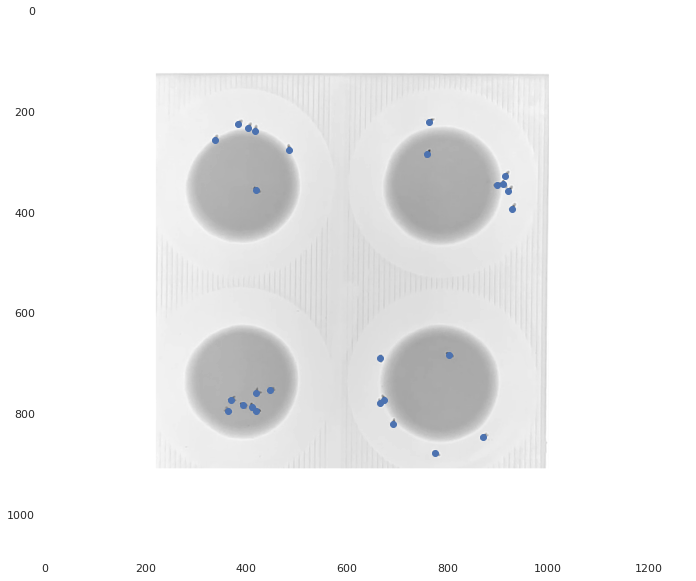

In [7]:
plt.figure(figsize=(15, 10))
plt.imshow(image, cmap='gray')

plt.scatter(*df.query(f"frame == {test_frame}")[["x", "y"]].to_numpy().T)
plt.grid(False)

In [9]:
# Getting pixels
threshold = 120
threshold_image = (image < threshold).astype("uint8")
fly_pixels = cv.findNonZero(threshold_image).squeeze()

In [10]:
# Getting initial value
init = df.query(f'frame == {test_frame-1}')[["x", "y"]].to_numpy().astype(np.float32)
n_flies = init.shape[0]

In [23]:
%%timeit
# sklearn baseline
reg = KMeans(n_clusters=n_flies, n_init=1, init=init, tol=1e-4, algorithm='full', )
sk_results = reg.fit(fly_pixels).cluster_centers_

1.94 ms ± 28.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%%timeit
# sklearn baseline
reg = KMeans(n_clusters=n_flies, n_init=1, init=init, tol=1e-4, algorithm='elkan', )
sk_results = reg.fit(fly_pixels).cluster_centers_

1.25 ms ± 23.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
reg = KMeans(n_clusters=n_flies, n_init=1, init=init, tol=1e-4, algorithm='full', )
sk_results = reg.fit(fly_pixels).cluster_centers_

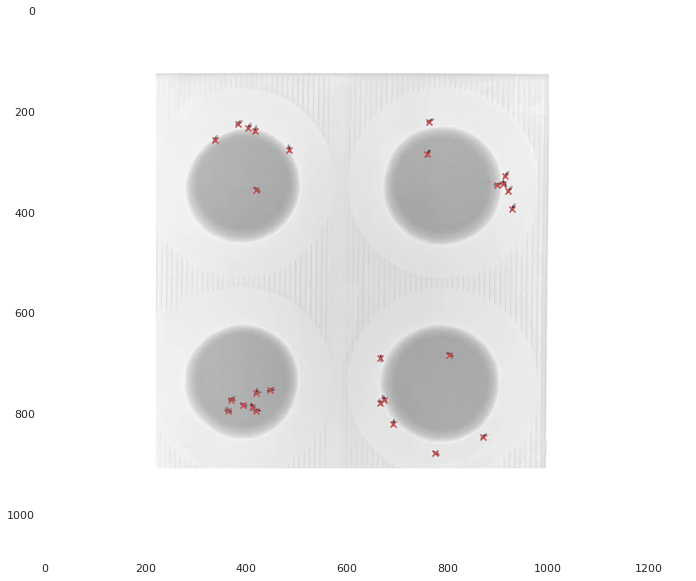

In [26]:
plt.figure(figsize=(15, 10))
plt.imshow(image, cmap='gray')
plt.scatter(*sk_results.T, marker='x', c='r')
plt.grid(False)

Now let's implement a pytorch kmeans

In [39]:
X, mu = torch.tensor(fly_pixels, dtype=torch.float32), torch.tensor(init, dtype=torch.float32)

<ipython-input-39-80afe734ed0f>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, mu = torch.tensor(fly_pixels, dtype=torch.float32), torch.tensor(init, dtype=torch.float32)


In [43]:
print(X.shape, mu.shape)

torch.Size([1354, 2]) torch.Size([27, 2])


In [46]:
dist_matrix = torch.cdist(X, mu)
labels = torch.argmin(dist_matrix, axis=1)
n_samples, n_clusters = dist_matrix.shape

In [112]:
M = torch.zeros((n_clusters, n_samples))
M[labels, torch.arange(n_samples)] = 1.0

In [113]:
%%timeit
mu = torch.matmul(M , X) / torch.sum(M, axis=1, keepdim=True)

31.2 µs ± 84 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
def kmeans(X, init, tol=1e-4):
    def step(X, mu):
        # E step
        dist_matrix = torch.cdist(X, mu)
        labels = torch.argmin(dist_matrix, axis=1)
        
        # M step
        M.zero_()[labels, torch.arange(n_samples)] = 1.0 # Resetting and updating in place
        mu = torch.matmul(M , X) / torch.sum(M, axis=1, keepdim=True)
        return mu, labels
    
    n_samples, n_clusters = X.shape[0], mu.shape[0]
    M = torch.zeros((n_clusters, n_samples))
    
    new_centers, old_centers = step(X, init)[0], init
    while torch.linalg.norm(new_centers - old_centers) > tol:
        new_centers, old_centers = step(X, new_centers)[0], new_centers
    new_centers, labels = step(X, new_centers)
    return new_centers, labels

In [99]:
%%timeit
torch_results, labels = kmeans(X, init)

694 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [101]:
torch_results, labels = kmeans(X, init)

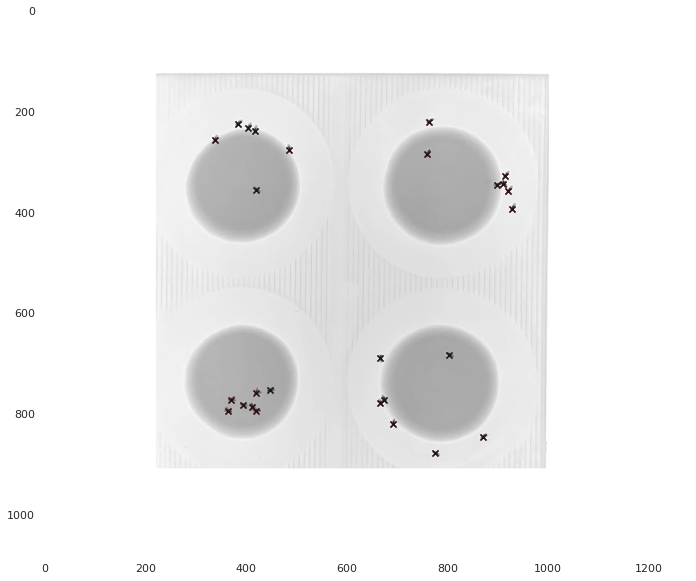

In [102]:
plt.figure(figsize=(15, 10))
plt.imshow(image, cmap='gray')
plt.scatter(*torch_results.T, marker='x', c='r')
plt.scatter(*sk_results.T, marker='x', c='k')
plt.grid(False)

In [62]:
def kmeans_torch(X, init, tol=1e-4):
    def step(X, mu):
        # E step
        dist_matrix = torch.cdist(X, mu)
        labels = torch.argmin(dist_matrix, axis=1)
        
        # M step
        M.zero_()  # resetting
        M[labels, torch.arange(n_samples)] = 1.0  #  updating in place
        mu = torch.matmul(M, X) / torch.sum(M, axis=1, keepdim=True)
        print(torch.any(torch.isnan(torch.matmul(M, X))))
        return mu, labels

    n_samples, n_clusters = X.shape[0], init.shape[0]
    M = torch.zeros((n_clusters, n_samples), dtype=torch.float32)

    new_centers, old_centers = step(X, init)[0], init
    while torch.linalg.norm(new_centers - old_centers) > tol:
        new_centers, old_centers = step(X, new_centers)[0], new_centers
    return new_centers

In [63]:
init_torch = torch.tensor(init, dtype=torch.float32)
pixels = torch.tensor(fly_pixels, dtype=torch.float32)

In [64]:
kmeans_torch(pixels, init_torch)

tensor(False)
tensor(False)


tensor([[775.1053, 879.1842],
        [690.6667, 819.6411],
        [673.4130, 771.9565],
        [927.4615, 392.4872],
        [910.8000, 343.8889],
        [898.8979, 345.3878],
        [420.2121, 794.4091],
        [363.7969, 795.3594],
        [411.1690, 786.5634],
        [393.1515, 783.3636],
        [370.3521, 772.2958],
        [665.8158, 779.5526],
        [419.7941, 758.6177],
        [447.6438, 753.8767],
        [919.9778, 357.6000],
        [763.4286, 219.7381],
        [870.0263, 846.1316],
        [802.3969, 683.4762],
        [913.6750, 328.0500],
        [665.8864, 689.6136],
        [419.6393, 356.0492],
        [759.7273, 283.6970],
        [484.8378, 276.0540],
        [403.6842, 232.0789],
        [416.3500, 238.8250],
        [383.2424, 224.5758],
        [337.0882, 256.6765]])

In [65]:
pixels_torch = torch.nonzero(torch.tensor(image) < threshold).type(torch.float32)

In [66]:
kmeans_torch(pixels_torch, init_torch)

tensor(False)


tensor([[     nan,      nan],
        [683.9623, 803.3774],
        [     nan,      nan],
        [     nan,      nan],
        [     nan,      nan],
        [792.4286, 417.1333],
        [395.4000, 925.6667],
        [320.3517, 867.4724],
        [     nan,      nan],
        [     nan,      nan],
        [287.6190, 757.2857],
        [680.9000, 797.2000],
        [     nan,      nan],
        [     nan,      nan],
        [     nan,      nan],
        [     nan,      nan],
        [862.6579, 822.5658],
        [789.4228, 676.5366],
        [     nan,      nan],
        [689.6136, 665.8864],
        [325.8469, 444.2551],
        [773.0722, 400.7433],
        [     nan,      nan],
        [     nan,      nan],
        [     nan,      nan],
        [     nan,      nan],
        [238.0000, 386.9103]])

In [67]:
pixels.shape

torch.Size([1354, 2])

In [68]:
pixels_torch.shape

torch.Size([1354, 2])

In [94]:
pixels_torch[:, [1, 0]]

tensor([[767., 216.],
        [768., 216.],
        [765., 217.],
        ...,
        [778., 882.],
        [779., 882.],
        [779., 883.]])

In [95]:
X = pixels_torch[:, [1, 0]]
mu = init_torch

In [96]:
# E step
dist_matrix = torch.cdist(X, mu)
labels = torch.argmin(dist_matrix, axis=1)

# M step
n_samples, n_clusters = X.shape[0], init.shape[0]
M = torch.zeros((n_clusters, n_samples), dtype=torch.float32)
M[labels, torch.arange(n_samples)] = 1.0  #  updating in place
updated_mu = torch.matmul(M, X) / torch.sum(M, axis=1, keepdim=True)

In [97]:
updated_mu

tensor([[775.1053, 879.1842],
        [690.6667, 819.6411],
        [673.4130, 771.9565],
        [927.4615, 392.4872],
        [910.8000, 343.8889],
        [898.8979, 345.3878],
        [420.2121, 794.4091],
        [363.7969, 795.3594],
        [411.1690, 786.5634],
        [393.1515, 783.3636],
        [370.3521, 772.2958],
        [665.8158, 779.5526],
        [419.7941, 758.6177],
        [447.6438, 753.8767],
        [919.9778, 357.6000],
        [763.4286, 219.7381],
        [870.0263, 846.1316],
        [802.3969, 683.4762],
        [913.6750, 328.0500],
        [665.8864, 689.6136],
        [419.6393, 356.0492],
        [759.7273, 283.6970],
        [484.8378, 276.0540],
        [403.6842, 232.0789],
        [416.3500, 238.8250],
        [383.2424, 224.5758],
        [337.0882, 256.6765]])

In [79]:
torch.sum(M, axis=1)

tensor([  0.,  53.,   0.,   0.,   0., 105.,  15., 290.,   0.,   0.,  21.,  10.,
          0.,   0.,   0.,   0.,  76., 123.,   0.,  44.,  98., 374.,   0.,   0.,
          0.,   0., 145.])

In [80]:
X.shape

torch.Size([1354, 2])

In [81]:
mu.shape

torch.Size([27, 2])

In [83]:
torch.sum(pixels, axis=0)

tensor([800250., 779713.])

In [84]:
torch.sum(pixels_torch, axis=0)

tensor([779713., 800250.])

In [100]:
from flytracker.utils import FourArenasQRCodeMask
from torch.utils.data import DataLoader
from flytracker.dataset import VideoDataset

In [101]:
mask = FourArenasQRCodeMask().mask
path = "/home/gert-jan/Documents/flyTracker/data/movies/4arenas_QR.h264"

dataset = VideoDataset(path, mask)
loader = DataLoader(dataset, batch_size=1)

In [107]:
idx, image = next(enumerate(loader))

In [109]:
image

tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [253, 253, 253,  ..., 237, 237, 237],
         [247, 247, 247,  ..., 225, 225, 225],
         [255, 255, 255,  ..., 253, 253, 253]]], dtype=torch.uint8)

TypeError: Invalid shape (1, 1080, 1280) for image data

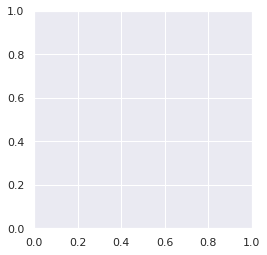

In [108]:
plt.imshow(image)

In [ ]:


    t_start = time.time()
    for batch_idx, sample in enumerate(loader):
        if batch_idx == 100:
            dataset.initializing = False
        if batch_idx % 100 == 0:
            print(f"Loaded {batch_idx}, {sample.device}")
    t_end = time.time()
    print(t_end - t_start)